In [14]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [15]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [16]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0906'): #churn_metric_0811
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

Reading cost_allocation/dev/churn_metric_0906.csv features


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [17]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [18]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [19]:
# hours_viewed = run_query('''SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation''')

In [63]:
hours_viewed = pd.read_csv('validation_data.csv')

In [64]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal', 'content_category', 'asset_run_time_hours']]

In [65]:
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre', 'content_category':'category'}, inplace = True)

In [24]:
hours_viewed.category.unique()

array(['movies', 'series', 'special', nan, 'livesports'], dtype=object)

In [25]:
churn_metric.category.unique()

array(['movies', 'series'], dtype=object)

In [66]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'] == 'special', 'category'] = 'movies'

In [67]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [68]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [69]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.015]

In [70]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


# Allocate the 60-Day Churn to monthly

## First 60 Allocation

In [71]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 60, 1)]

In [72]:
hours_viewed_thresh['key'] = 1
dt_df['key'] = 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [73]:
hours_viewed_60d = hours_viewed_thresh.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_60d['request_date'] = pd.to_datetime(hours_viewed_60d['offering_start_date']) \
                                    + pd.to_timedelta(hours_viewed_60d['days_on_hbo_max'], unit='D')

hours_viewed_60d['change_in_churn'] = hours_viewed_60d['change_in_churn_60d']/60

## After 60 Day Allocation

In [74]:
ever_green_titles = pd.read_csv('final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

In [75]:
ever_green_titles.head()

,Unnamed: 0,title_name,title_id,season_number,offering_start_date,content_category,program_type,air_date,medal,pillar_genre
0,5837,The Sopranos,GVU2b9AHpHo7DwvwIAT4i,1,2020-05-27,series,original,1999-04-04,None,Drama
1,21053,The Sopranos,GVU2b9AHpHo7DwvwIAT4i,2,2020-05-27,series,original,2000-04-09,None,Drama
2,40742,The Sopranos,GVU2b9AHpHo7DwvwIAT4i,3,2020-05-27,series,original,2001-05-20,None,Drama
3,60224,The Sopranos,GVU2b9AHpHo7DwvwIAT4i,4,2020-05-27,series,original,2002-12-08,None,Drama
4,38723,The Sopranos,GVU2b9AHpHo7DwvwIAT4i,5,2020-05-27,series,original,2004-06-06,None,Drama


In [36]:
len(ever_green_titles.title_id.unique())

11

In [37]:
len(hours_viewed_thresh.title_id.unique())

740

In [38]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['American Pie', 'Annabelle Comes Home', 'Curb Your Enthusiasm',
       'Friends', 'Game of Thrones', 'Pretty Little Liars',
       'Sex and the City', 'The Big Bang Theory', 'The Sopranos',
       'War Dogs', 'X-Men: Dark Phoenix'], dtype=object)

In [39]:
ever_green_title_id = ever_green_titles.title_id.unique()

In [40]:
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [41]:
from scipy.optimize import curve_fit

In [42]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [43]:
historical_weekly_hours_viewed = pd.read_csv('historical_weekly_hours_viewed.csv')

In [44]:
historical_weekly_hours_viewed.head()

,Unnamed: 0,days_on_hbo_max,monthly_average_hours_viewed,monthly_average_hours_viewed_60d,target
0,0,63,0.001131,0.001131,1.000000
1,1,70,0.001047,0.001131,0.926029
2,2,77,0.000958,0.001131,0.846706
3,3,84,0.000867,0.001131,0.766149
4,4,91,0.000820,0.001131,0.725386


In [45]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = historical_weekly_hours_viewed['days_on_hbo_max']-63
y = historical_weekly_hours_viewed['target']

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
popt #0.00059137, 0.03019112, 0.00055421

array([0.52286596, 0.03019111, 0.49000708])

In [47]:
# popt = [0.52286596, 0.03019111, 0]

In [48]:
x1 = pd.Series(np.arange(0,300,1))
y1 = func(x1, *popt)

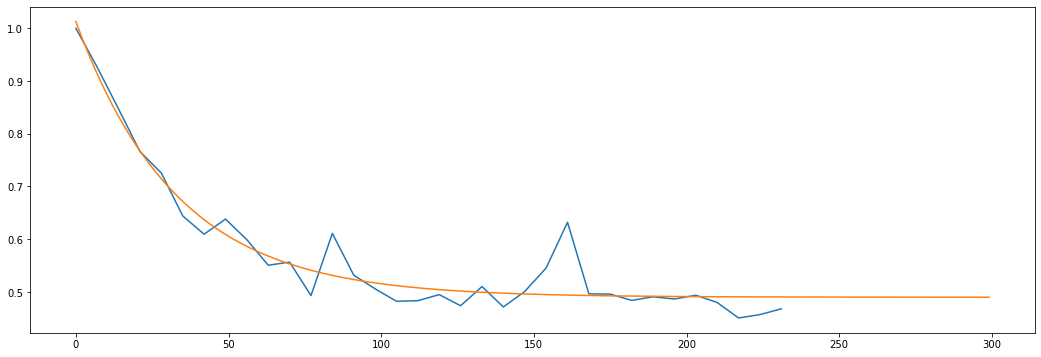

In [49]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y)
plt.plot(x1, y1)
plt.show()

In [50]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 1000, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max'], *popt)
dt_df['key'] = 1

In [51]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)]

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/60*hours_viewed_decay_norm['factor']

hours_viewed_decay_norm['days_on_hbo_max'] = hours_viewed_decay_norm['days_on_hbo_max']+60

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']


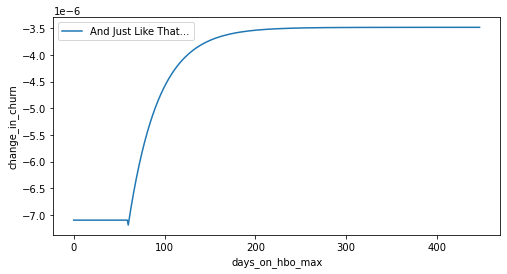

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]],
                axis = 0)
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [53]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [54]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [55]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [56]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60

hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


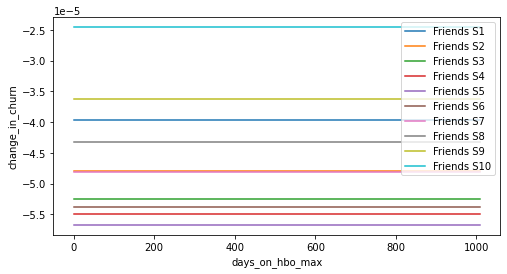

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [58]:
data = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [76]:
hours_viewed_thresh.head()

,title_name,title_id,season_number,offering_start_date,average_hours_viewed_60d,genre,medal,category,asset_run_time_hours,churn_per_hr_person,change_in_churn_60d,key
21,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,2020-07-01,0.041448,other,Bronze,movies,1.516111,-0.033936,-0.001407,1
129,My Big Fat Greek Wedding,GVWIojg4qrMJtGzYJAAXw,0,2020-05-27,0.022473,other,Bronze,movies,1.581944,-0.033936,-0.000763,1
140,The Family Man,GV_5_nw7iecJPqAEAAAAi,0,2020-12-01,0.030645,other,Bronze,movies,2.095555,-0.033936,-0.001040,1
162,Home Alone,GVhw_fww_gIuuJyYKAABA,0,2020-06-01,0.028313,other,Bronze,movies,1.712777,-0.033936,-0.000961,1
171,Dr. Seuss' How the Grinch Stole Christmas,GVnRuCAA79Z3Dww0JAADm,0,2022-02-01,0.020602,other,Bronze,movies,1.712222,-0.033936,-0.000699,1


In [77]:
data = data.merge(hours_viewed_thresh[['title_id', 'season_number', 'average_hours_viewed_60d', 'churn_per_hr_person', 'change_in_churn_60d', 'asset_run_time_hours']],
                 on = ['title_id', 'season_number'])

In [78]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [79]:
# data.groupby(['date_month']).change_in_churn.sum().reset_index().sort_values(by = ['date_month'])

In [84]:
data[data['title_id'] == 'GX9KHPw1OIMPCJgEAAAAD']

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
705755,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-25,0,-0.000710,1.501944,-0.028358,-0.042593,2.466944,2020-12
705756,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-26,1,-0.000710,1.501944,-0.028358,-0.042593,2.466944,2020-12
705757,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-27,2,-0.000710,1.501944,-0.028358,-0.042593,2.466944,2020-12
705758,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-28,3,-0.000710,1.501944,-0.028358,-0.042593,2.466944,2020-12
705759,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-29,4,-0.000710,1.501944,-0.028358,-0.042593,2.466944,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706547,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-25,792,-0.000348,1.501944,-0.028358,-0.042593,2.466944,2023-02
706548,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-26,793,-0.000348,1.501944,-0.028358,-0.042593,2.466944,2023-02
706549,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-27,794,-0.000348,1.501944,-0.028358,-0.042593,2.466944,2023-02
706550,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-28,795,-0.000348,1.501944,-0.028358,-0.042593,2.466944,2023-02


In [81]:
data[data['date_month'] == '2022-09'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours
860,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,615,-0.000348,1.501944,-0.028358,-0.042593,2.466944
737,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,580,-0.000229,0.928905,-0.030182,-0.028036,2.101111
235,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,190,-0.000212,0.937395,-0.027117,-0.025419,1.915833
731,The King's Man,GYeGXugg4ewPCwgEAABi1,0,195,-0.000210,0.892226,-0.028358,-0.025302,2.176666
293,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,243,-0.000197,0.918052,-0.026197,-0.024050,1.680555
545,Scoob!,GXtf0UwTqw8JHjQEAAAbT,0,797,-0.000185,0.538185,-0.042203,-0.022713,1.519444
41,An American Pickle,GXyIYDACdyMNlkwEAAAAE,0,756,-0.000169,0.489954,-0.042203,-0.020678,1.428611
643,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,136,-0.000163,0.634560,-0.028358,-0.017995,2.936666
232,Ford v Ferrari,GXpTQQAAyyAwlRQEAABgA,0,802,-0.000156,0.393502,-0.048567,-0.019111,2.547500
318,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,10,-0.000153,0.500364,-0.018346,-0.009180,10.259162


In [195]:
# data[(data['request_date'] == '2023-03-01')
#     &(data['title_name'] == 'Friends')].sort_values(by = ['change_in_churn']).head(20)

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [70]:
churn_genpop = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
and SUB_MONTH >1
group by 1
order by 1
''')

In [ ]:
churn_genpop_tenure = run_query('''
select
     dt.start_date as date_month, sub_month as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [ ]:
churn_exclude_t1 = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
AND SUB_MONTH > 1
group by 1
order by 1
''')

In [102]:
churn_genpop.head()

,date_month,churns,total_subs,churn_rate
0,2020-06-01,9,84,0.107143
1,2020-07-01,2125,31493,0.067475
2,2020-08-01,77090,794407,0.097041
3,2020-09-01,92234,1014273,0.090936
4,2020-10-01,107861,1230141,0.087682


In [264]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

#### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

#### Shift one month forward
# aggregated_churn['date_month']  = (pd.to_datetime(aggregated_churn['date_month']) + pd.DateOffset(months=1)).dt.strftime('%Y-%m-%d')

In [265]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [266]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [267]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [268]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1
0,2020-06-01,0.081925,0.416667,0.059701,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.107143,0.107143
1,2020-07-01,0.147216,0.067450,0.125000,0.030769,0.000000,0.000000,0,0,0.500000,...,0,0,0,0,0.000000,0,0,0,0.067475,0.067473
2,2020-08-01,0.246896,0.098401,0.061422,0.068966,0.046875,0.000000,0.000000,0,0.000000,...,0.000000,0,0,0,0,0.000000,0,0,0.097041,0.097041
3,2020-09-01,0.266349,0.131667,0.073671,0.047285,0.640000,0.949153,0.000000,0.000000,0,...,0.000000,0.000000,0,0,0,0,0.000000,0,0.090936,0.090936
4,2020-10-01,0.232411,0.143210,0.101009,0.059563,0.040794,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0,0,0,0,0.000000,0.087682,0.087682


In [269]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [270]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [271]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [272]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [273]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1,-0.395155
2,-0.015996
3,0.163179
4,0.119275
5,0.315361
6,0.794413
7,0.425039
8,0.096690
9,0.308781
10,0.300982


<AxesSubplot:>

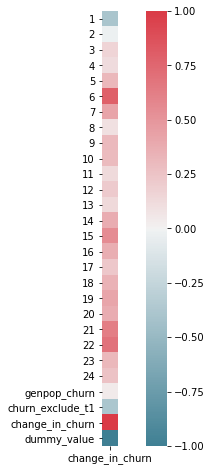

In [274]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

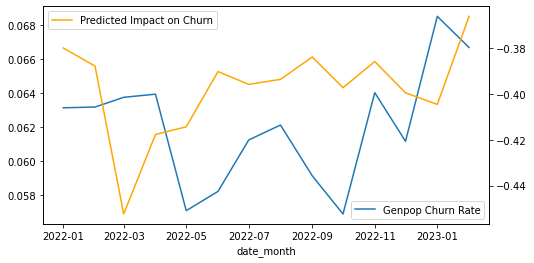

In [290]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

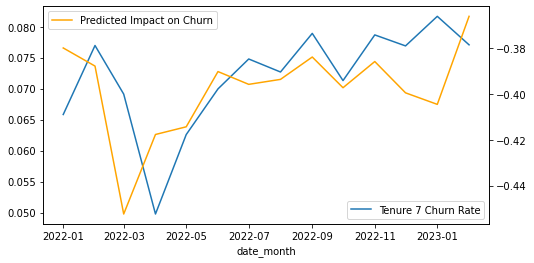

In [276]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

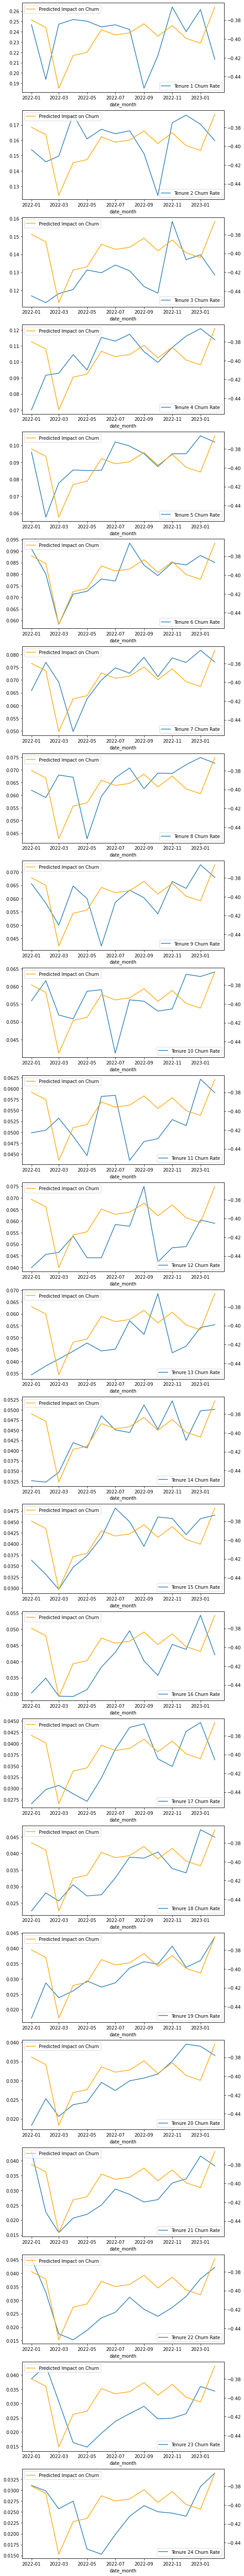

In [277]:
# fig, ax = plt.subplots(figsize=(8, 4))
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(24,1,figsize=(8, 104))

for i in range(0, 24, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Tenure Buckets

In [ ]:
churn_genpop_tenure_bucekts = run_query('''
select
     dt.start_date as date_month, 
     case when sub_month <=3 then '1-3'
          when sub_month <=6 then '4-6'
          when sub_month <=12 then '7-12'
          when sub_month <=24 then '13-24'
          else '24+'
     end as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
--and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [278]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [279]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

In [280]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [281]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [282]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [283]:
churn_bucekts_all.head()

,date_month,1-3,13-24,24+,4-6,7-12,genpop_churn,churn_exclude_t1,change_in_churn
0,2022-01-01,0.191762,0.027711,0.028278,0.081849,0.057722,0.063140,0.063128,-0.379784
1,2022-02-01,0.164485,0.031045,0.021768,0.072944,0.058322,0.063184,0.063168,-0.387705
2,2022-03-01,0.170197,0.027813,0.027384,0.072797,0.054829,0.063757,0.063743,-0.452362
3,2022-04-01,0.172488,0.029994,0.028602,0.090079,0.054364,0.063942,0.063927,-0.417602
4,2022-05-01,0.188415,0.030916,0.027337,0.087246,0.050639,0.057086,0.057072,-0.414247


In [284]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['1-3', '4-6', '7-12', '13-24','24+', 'genpop_churn']

In [285]:
FEATURE_COLS

['1-3', '4-6', '7-12', '13-24', '24+', 'genpop_churn']

In [286]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [287]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [288]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1-3,0.103780
4-6,0.363347
7-12,0.491879
13-24,0.460324
24+,-0.391809
genpop_churn,0.040228
change_in_churn,1.000000
dummy_value,-1.000000


<AxesSubplot:>

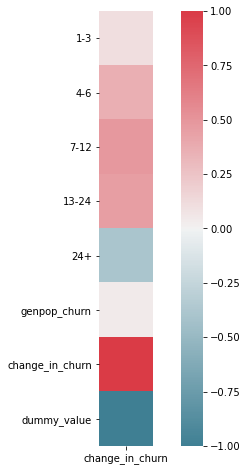

In [289]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Write to S3/SF

In [85]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [86]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [87]:
data.head()

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
0,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-01,0,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
1,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-02,1,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
2,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-03,2,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
3,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-04,3,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
4,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-05,4,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07


In [88]:
data.to_csv('daily_monthly_retention_value.csv')

In [89]:
write_to_sf(data, 'daily_monthly_retention_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [90]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format('daily_monthly_retention_value')

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv'

In [56]:
data[data['date_month'] == '2022-12'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn
502,Euphoria,GXKN_xQX5csPDwwEAAABj,2,10540,-0.008531
742,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,3596,-0.003057
785,Injustice,GYbvoqgoeYawYwwEAAAAN,0,10323,-0.002646
856,Kong: Skull Island,GX-nzMwc-EaCFpgEAAAMh,0,22134,-0.002619
694,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,10819,-0.002506
1515,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,7502,-0.002218
570,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,9176,-0.002047
1671,The King's Man,GYeGXugg4ewPCwgEAABi1,0,9331,-0.001959
579,Friends,GXdbR_gOXWJuAuwEAACVH,5,28923,-0.001759
578,Friends,GXdbR_gOXWJuAuwEAACVH,4,28923,-0.001702
